# Introduction

- Doesn't give correct stress-strain for `poly_deg` > 1. I have tried lower tolerances (1e-10) for Newton solver, higher quadrature degree (3), smaller time step (0.0001), and higher number of element (1000) but to no avail.
- Power-law and Panteghini & Bardella flow rules give slightly different results, in absolute values and the shape of the transition. Power law gives more strengthening in case of dissipative lenght-scale case. Also transition is smoother with Power-law.

# Notes

For code references see:

https://docs.fenicsproject.org/dolfinx/v0.8.0/python/demos/demo_cahn-hilliard.html

https://bleyerj.github.io/comet-fenicsx/tours/nonlinear_problems/plasticity/plasticity.html

# Imports

In [175]:
# Note that it is important to first from mpi4py import MPI to ensure that MPI is correctly initialised
from mpi4py import MPI

In [176]:
import basix
import numpy as np
import pandas as pd
import pyvista as pv
import ufl
from dolfinx import fem, log, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from matplotlib import pyplot as plt
from petsc4py import PETSc

In [177]:
log.set_output_file("log.txt")

# Parameters

In [178]:
x_min = 0.0
x_max = 10.0

u_max = 1.0
t_max = 0.5
dt = 0.001

S0 = 100
μ = 100e3
d0 = 0.1
m = 0.02
le = 10.0
ld = 0.0
H = 500.0
ε0_dot = 3e-4

num_elems = 100

poly_deg = 1
quad_deg = 2

# rate_fn_type = "power-law" # Other choice is "panteghini-and-bardella"
rate_fn_type = "panteghini-and-bardella"

In [179]:
length = x_max - x_min

# Mesh

In [180]:
domain = mesh.create_interval(MPI.COMM_WORLD, num_elems, [x_min, x_max])

topology_dim = domain.topology.dim
face_dim = topology_dim - 1

In [181]:
grid = pv.UnstructuredGrid(*plot.vtk_mesh(domain))
plotter = pv.Plotter()
plotter.add_mesh(grid, show_vertices=True)
plotter.view_xy()
plotter.zoom_camera(2)
plotter.show_axes()
plotter.screenshot("grid.png")
plotter.show()

Widget(value='<iframe src="http://localhost:40925/index.html?ui=P_0x7da43235c140_7&reconnect=auto" class="pyvi…

# Function spaces

In [182]:
u_elem = basix.ufl.element("Lagrange", domain.basix_cell(), poly_deg)
γp_elem = basix.ufl.element("Lagrange", domain.basix_cell(), poly_deg)

mixed_elem = basix.ufl.mixed_element([u_elem, γp_elem])
mixed_space = fem.functionspace(domain, mixed_elem)

In [183]:
u_subspace = mixed_space.sub(0)
γp_subspace = mixed_space.sub(1)

# Boundary conditions

In [184]:
def fixed_boundary(x):
    return np.isclose(x[0], x_min)


def loading_boundary(x):
    return np.isclose(x[0], x_max)

In [185]:
fixed_facets = mesh.locate_entities_boundary(domain, face_dim, fixed_boundary)
fixed_u_dofs = fem.locate_dofs_topological(u_subspace, face_dim, fixed_facets)
fixed_u_bc = fem.dirichletbc(0.0, fixed_u_dofs, u_subspace)

loading_facets = mesh.locate_entities_boundary(domain, face_dim, loading_boundary)
loading_u_dofs = fem.locate_dofs_topological(u_subspace, face_dim, loading_facets)
u_load = fem.Constant(domain, 0.0)
loading_u_bc = fem.dirichletbc(u_load, loading_u_dofs, u_subspace)

u_bcs = [fixed_u_bc, loading_u_bc]


In [186]:
domain.topology.create_connectivity(face_dim, topology_dim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
fixed_γp_dofs = fem.locate_dofs_topological(γp_subspace, face_dim, boundary_facets)
fixed_γp_bc = fem.dirichletbc(0.0, fixed_γp_dofs, γp_subspace)

γp_bcs = [fixed_γp_bc]

In [187]:
if (le == 0) and (ld == 0):
    bcs = u_bcs
else:
    bcs = u_bcs + γp_bcs

# Quadrature element

In [188]:
quad_elem = basix.ufl.quadrature_element(
    domain.basix_cell(), value_shape=(), scheme="default", degree=quad_deg
)

quad_space = fem.functionspace(domain, quad_elem)

In [189]:
S_old = fem.Function(quad_space)
S_old.vector.set(S0)
S = fem.Function(quad_space)
S.vector.set(S0)

In [190]:
basix_celltype = getattr(basix.CellType, domain.topology.cell_type.name)
quadrature_points, weights = basix.make_quadrature(basix_celltype, quad_deg)

map_c = domain.topology.index_map(domain.topology.dim)
num_cells = map_c.size_local + map_c.num_ghosts
cells = np.arange(0, num_cells, dtype=np.int32)


def interpolate_quadrature(ufl_expr, function):
    expr_expr = fem.Expression(ufl_expr, quadrature_points)
    expr_eval = expr_expr.eval(domain, cells)
    function.x.array[:] = expr_eval.flatten()[:]

# Material model

In [191]:
def constitutive_update(U, U0, S_old, S):
    u, γp = ufl.split(U)
    _, γp0 = ufl.split(U0)
    τ = μ * (ufl.grad(u)[0] - γp)
    γp_dot = (γp - γp0) / dt
    # make sure the quantity inside ufl.sqrt is never zero by adding a very small float,
    # otherwise dp will become imaginary.
    dp = ufl.sqrt(γp_dot**2 + ld**2 * (ufl.grad(γp_dot)[0]) ** 2 + 1e-12)

    if rate_fn_type == "power-law":
        V = (dp / d0)**m
    elif rate_fn_type == "panteghini-and-bardella":
        V = ufl.conditional(
            ufl.le(dp / ε0_dot, 1), dp / (2 * ε0_dot), 1 - ε0_dot / (2 * dp)
        )
    τp = S * V * γp_dot / dp
    kp = S0 * le**2 * ufl.grad(γp)[0] + S0 * ld**2 * V * ufl.grad(γp_dot)[0] / dp
    S_expr = S_old + H * dp * dt
    return τ, τp, kp, S_expr

In [192]:
U = fem.Function(mixed_space)
U0 = fem.Function(mixed_space)
τ, τp, kp, S_expr = constitutive_update(U, U0, S_old, S)

# Weak form

In [193]:
dx = ufl.Measure(
    "dx",
    domain=domain,
    metadata={"quadrature_degree": quad_deg, "quadrature_scheme": "default"},
)

u_, γp_ = ufl.TestFunctions(mixed_space)

# Weak statement of the equations
F0 = ufl.inner(τ, ufl.grad(u_)[0]) * ufl.dx
F1 = ufl.inner((τp - τ), γp_) * ufl.dx
if (le != 0) or (ld != 0): # make sure kp isn't zero; otherwise, it gives error
    F1 += ufl.inner(kp, ufl.grad(γp_)[0]) * ufl.dx
F = F0 + F1

# Linear problem

In [194]:
class CustomLinearProblem(LinearProblem):
    def assemble_rhs(self, u=None):
        """Assemble right-hand side and lift Dirichlet bcs.

        Parameters
        ----------
        u : dolfinx.fem.Function, optional
            For non-zero Dirichlet bcs u_D, use this function to assemble rhs with the value u_D - u_{bc}
            where u_{bc} is the value of the given u at the corresponding. Typically used for custom Newton methods
            with non-zero Dirichlet bcs.
        """

        # Assemble rhs
        with self._b.localForm() as b_loc:
            b_loc.set(0)
        fem.petsc.assemble_vector(self._b, self._L)

        # Apply boundary conditions to the rhs
        x0 = [] if u is None else [u.vector]
        fem.petsc.apply_lifting(self._b, [self._a], bcs=[self.bcs], x0=x0, scale=1.0)
        self._b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        x0 = None if u is None else u.vector
        fem.petsc.set_bc(self._b, self.bcs, x0, scale=1.0)

    def assemble_lhs(self):
        self._A.zeroEntries()
        fem.petsc.assemble_matrix_mat(self._A, self._a, bcs=self.bcs)
        self._A.assemble()

    def solve_system(self):
        # Solve linear system and update ghost values in the solution
        self._solver.solve(self._b, self._x)
        self.u.x.scatter_forward()

In [195]:
residual = F
tangent = ufl.derivative(F, U)

dU = fem.Function(mixed_space)

tangent_problem = CustomLinearProblem(
    tangent,
    -residual,
    u=dU,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
)

# Newton-Raphson

In [196]:
iter_max, tol = 200, 1e-6  # parameters of the Newton-Raphson procedure

t = 0.0
τ_history = [0]
Γ_history = [0]
τ_space = fem.functionspace(domain, ("DG", 0))
τ_t = fem.Function(τ_space)

while t < t_max:
    t += dt
    u_load.value = u_max / t_max * t
    Γ_history.append(u_load.value / length)

    tangent_problem.assemble_rhs(U)
    res0 = tangent_problem._b.norm()
    res = res0

    iter = 0
    while res / res0 > tol and iter < iter_max:
        tangent_problem.assemble_lhs()
        tangent_problem.solve_system()

        U.vector.axpy(0.5, dU.vector)  # U = U + 1 * dU
        U.x.scatter_forward()

        interpolate_quadrature(S_expr, S)

        # compute the new residual
        tangent_problem.assemble_rhs(U)
        res = tangent_problem._b.norm()

        iter += 1

    print(f"Step {int(t / dt)}: num iterations: {iter}, {res/res0}")
    U0.x.array[:] = U.x.array
    S_old.x.array[:] = S.x.array
    τ_t.interpolate(fem.Expression(τ, τ_space.element.interpolation_points()))
    τ_history.append(τ_t.x.array[-1])

Step 1: num iterations: 20, 9.53674315737816e-07
Step 2: num iterations: 20, 9.536743092903119e-07
Step 3: num iterations: 20, 9.538453553093828e-07
Step 4: num iterations: 20, 9.558588545420427e-07
Step 5: num iterations: 21, 5.514114226973736e-07
Step 6: num iterations: 21, 5.294215589213329e-07
Step 7: num iterations: 21, 5.288925517318873e-07
Step 8: num iterations: 21, 5.290268282083946e-07
Step 9: num iterations: 21, 5.291635763159075e-07
Step 10: num iterations: 21, 5.29300505915597e-07
Step 11: num iterations: 21, 5.294376202516113e-07
Step 12: num iterations: 21, 5.295749223628322e-07
Step 13: num iterations: 21, 5.297124179143019e-07
Step 14: num iterations: 21, 5.298501018667588e-07
Step 15: num iterations: 21, 5.299879843900489e-07
Step 16: num iterations: 21, 5.30126058662849e-07
Step 17: num iterations: 21, 5.302643346255358e-07
Step 18: num iterations: 21, 5.304028091673669e-07
Step 19: num iterations: 21, 5.305414925682725e-07
Step 20: num iterations: 21, 5.306803699060

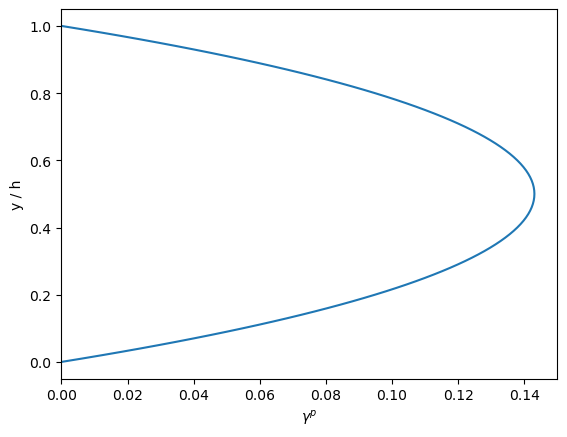

In [197]:
γp_space, γp_dofs = mixed_space.sub(1).collapse()
γp_final = U.x.array[γp_dofs]

x_coords = γp_space.tabulate_dof_coordinates()[:, 0]
sort_ids = x_coords.argsort()

x_coords_sorted = x_coords[sort_ids]
γp_final_sorted = γp_final[sort_ids]

pd.DataFrame({'gamma_p': γp_final_sorted, 'x_coords': x_coords_sorted}).to_csv(f"gamma_p_profile_le{le}_ld{ld}_H{H}.csv", index=False)

plt.plot(γp_final_sorted, x_coords_sorted / length)
plt.xlabel(r"$\gamma^p$")
plt.ylabel("y / h")
plt.xlim([0, 0.15])
plt.savefig("gamma_profile.png")
plt.show()

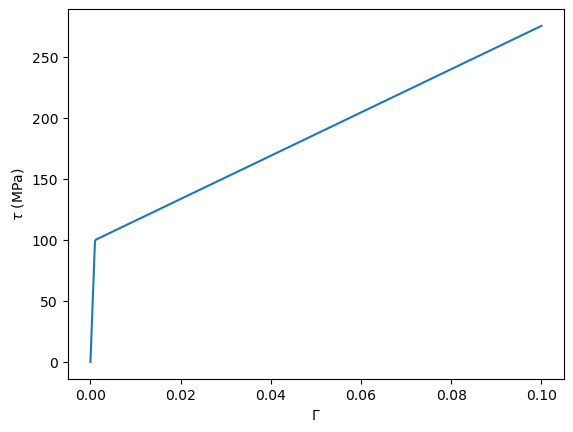

In [198]:
pd.DataFrame({'gamma': Γ_history, 'tau': τ_history}).to_csv(f"stress-strain_le{le}_ld{ld}_H{H}.csv", index=False)

plt.plot(Γ_history, τ_history)
plt.xlabel(r"$\Gamma$")
plt.ylabel(r"$\tau$ (MPa)")
plt.savefig("stress-strain.png")
plt.show()

# References
- Bardella, L., & Panteghini, A. (2015). Modelling the torsion of thin metal wires by distortion gradient plasticity. Journal of the Mechanics and Physics of Solids, 78, 467–492. https://doi.org/10.1016/j.jmps.2015.03.003
- Panteghini, A., & Bardella, L. (2016). On the Finite Element implementation of higher-order gradient plasticity, with focus on theories based on plastic distortion incompatibility. Computer Methods in Applied Mechanics and Engineering, 310, 840–865. https://doi.org/10.1016/j.cma.2016.07.045